In [156]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import RandomSampler

import math
from typing import Tuple
from dataclasses import dataclass, field
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

DEVICE = torch.device('cpu')

## Data

In [188]:
@dataclass
class CharacterTokenizer:
    decode_dict: dict[int, str] = field(default_factory=dict)
    encode_dict: dict[str, int] = field(default_factory=dict)

    def get_vocab(self):
        """Character to int mapping"""
        return self.encode_dict

    def train(self, input_str: str) -> None:
        """Determine what character will be mapped to which int using lexicograpical order"""
        chars = sorted(set(input_str))
        self.decode_dict: dict[int, str] = dict(enumerate(chars))
        self.encode_dict: dict[str, int] = {v:k for k,v in self.decode_dict.items()}

    def encode(self, input: str) -> list[int]:
        """Turn a string into a list of ints using a pretrained lookup table"""
        return [self.encode_dict[char] for char in input]

    def decode(self, tokens: list[int]) -> str:
        """Turn a list of ints into a string using a reverse lookup table"""
        return ''.join(self.decode_dict[token] for token in tokens)

class CharacterDataset:
    def __init__(self, data: str, tokenizer: CharacterTokenizer, context_size: int=256):
        self.data = data
        self.tokenizer = tokenizer
        self.vocab_size = len(tokenizer.get_vocab())
        self.context_size = context_size

    def __repr__(self):
        n_chars = len(self.data)
        vocab_size = self.vocab_size
        context_size = self.context_size
        return f'CharacterDataset({n_chars=}, {vocab_size=}, {block_size=})'

    @classmethod
    def from_textfile(cls, filename: str, context_size: int=256) -> 'CharacterDataset':
        """Load a textfile and automatically 'train' a character level tokenizer"""
        tokenizer = CharacterTokenizer()
        with open(filename, 'r') as fh:
            data = fh.read()
            tokenizer.train(data)
            return cls(data, tokenizer, context_size=context_size)

    def train_test_split(self, train_percentage: float=0.8) -> Tuple['CharacterDataset','CharacterDataset']:
        n_train_chars = int(train_percentage * len(self.data))

        train_data = self.data[:n_train_chars]
        train_dataset = CharacterDataset(train_data, self.tokenizer, self.context_size)

        test_data = self.data[n_train_chars:]
        test_dataset = CharacterDataset(test_data, self.tokenizer, self.context_size)

        return train_dataset, test_dataset

    def __len__(self) -> int:
        return len(self.data) - self.context_size

    def __getitem__(self, pos: int) -> torch.tensor:
        """Return tokens starting at pos up to pos + context_size, targets are shifted by one position"""
        # grab a chunk of block_size characters from the data
        chunk = self.data[pos:pos + self.context_size + 1]
        # encode every character to an integer
        tokens = self.tokenizer.encode(chunk)
        # convert to tensor
        tokens = torch.tensor(tokens, dtype=torch.long)
        # targets are shifted one position from input
        return tokens[:-1], tokens[1:]

dataset = CharacterDataset.from_textfile('./input.txt')
train_dataset,test_dataset = dataset.train_test_split()
len(train_dataset),len(test_dataset)

(892059, 222823)

## Model

In [187]:
class MLP(nn.Module):
    """Simple multi-layer perceptron with two linear layers and a relu non-linearity in between"""
    def __init__(self, embedding_dim: int, bias: bool = False):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=4 * embedding_dim, bias=bias),
            nn.ReLU(),
            nn.Linear(in_features=4 * embedding_dim, out_features=embedding_dim, bias=bias),
        )

    def forward(self, x: torch.tensor) -> torch.tensor:
        return self.mlp(x)

class DotProductAttention(nn.Module):
    """"""
    def __init__(self, embedding_dim: int, bias: bool=False):
        super().__init__()
        self.w_k = nn.Linear(in_features=embedding_dim, out_features=embedding_dim, bias=bias)
        self.w_q = nn.Linear(in_features=embedding_dim, out_features=embedding_dim, bias=bias)
        self.w_v = nn.Linear(in_features=embedding_dim, out_features=embedding_dim, bias=bias)

    def forward(self, x: torch.tensor) -> torch.tensor:
        _,embedding_dim = x.size()
        
        k = self.w_k(x)
        q = self.w_q(x)
        v = self.w_v(x)

        attention = (k @ q.T) / math.sqrt(embedding_dim)

        return F.softmax(attention, dim=-1) @ v
        
        
class TransformerBlock(nn.Module):
    """Transformer block that combines attention and MLP, both with pre-layernorm and residual connections"""
    def __init__(self, embedding_dim: int, bias: bool = False):
        super().__init__()
        self.attention = nn.Sequential(
            nn.LayerNorm(embedding_dim, bias=bias),
            DotProductAttention(embedding_dim=embedding_dim, bias=bias)
        )
        self.projection = nn.Sequential(
            nn.LayerNorm(embedding_dim, bias=bias),
            MLP(embedding_dim=embedding_dim, bias=bias)
        )

    def forward(self, x: torch.tensor) -> torch.tensor:
        attn = x + self.attention(x)
        proj = attn + self.projection(attn)
        return proj

class AdditivePositionalEmbedding(nn.Module):
    """Wrapper class to add positional encoding to embedded tokens"""
    def __init__(self, context_size: int, embedding_dim: int):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=context_size, embedding_dim=embedding_dim)

    def forward(self, x: torch.tensor) -> torch.tensor:
        pos = torch.arange(0, x.size(0), dtype=torch.long, device=x.device)
        return self.embedding(pos) + x

class NaiveTransformer(nn.Module):
    """"""
    def __init__(self, context_size: int, vocab_size: int, n_layers: int=4, embedding_dim: int=256):
        super().__init__()
        self.transformer = nn.Sequential(
            nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim), # token embedding
            AdditivePositionalEmbedding(context_size, embedding_dim), # position embedding
            nn.Sequential(*(TransformerBlock(embedding_dim=embedding_dim) for _ in range(n_layers))), # attention layers
            nn.Linear(in_features=embedding_dim, out_features=vocab_size, bias=False) # output projection
        )

    def forward(self, x: torch.tensor, targets: torch.tensor=None) -> tuple[torch.tensor, torch.tensor]:
        logits = self.transformer(x)
        loss = None if targets is None else F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, sample_length: int=256):
        pass

model = NaiveTransformer(context_size=dataset.context_size, vocab_size=dataset.vocab_size)

In [179]:
x.size(0)

256

TransformerConfig(context_size=256, vocab_size=65, n_layers=4, embedding_dim=128)


  0%|          | 0/100 [00:00<?, ?it/s]

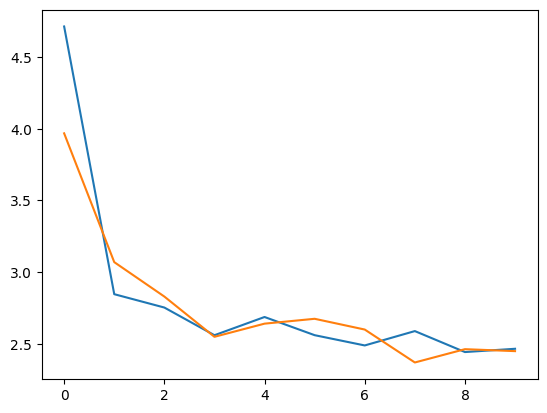

In [181]:
dataset = CharacterDataset.from_textfile('./input.txt', context_size=256)
train_dataset, test_dataset = dataset.train_test_split()

config = TransformerConfig(context_size=dataset.context_size, vocab_size=dataset.vocab_size, embedding_dim=128)

print(config)

model = NaiveTransformer(config)
model = model.to(DEVICE)

train_dataloader = DataLoader(
    dataset=train_dataset,
    sampler=RandomSampler(train_dataset, replacement=False, num_samples=5000),
    batch_size=50
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    sampler=RandomSampler(test_dataset, replacement=False, num_samples=1000),
    batch_size=10
)
test_dataloader = iter(test_dataloader)

train_loss = []
test_loss = []

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

for i, train_batch in enumerate(tqdm(train_dataloader)):
    model.zero_grad()
    for x,y in zip(*train_batch):
        _,loss = model(x.to(DEVICE), y.to(DEVICE))
        # backprop and update the parameters
        
        loss.backward()
    optimizer.step()
        
    if i % 10 == 0:
        test_x, test_y = next(test_dataloader)
        test_loss.append(model(test_x[0].to(DEVICE), test_y[0].to(DEVICE))[1].item())
        train_loss.append(loss.item())

plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')